In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_distribution
from math import gcd
from numpy.random import randint
from numpy import pi

In [2]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
my_backends = provider.backends(min_num_qubits=5, simulator=False, operational=True)

for backend in my_backends:
    print(backend) # only available for 7-qubit device

<IBMBackend('ibmq_lima')>
<IBMBackend('ibm_perth')>
<IBMBackend('ibmq_quito')>
<IBMBackend('ibmq_belem')>
<IBMBackend('ibmq_manila')>
<IBMBackend('ibm_nairobi')>
<IBMBackend('ibm_lagos')>
<IBMBackend('ibmq_jakarta')>


In [3]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

In [4]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

In [5]:
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [6]:
qc = QuantumCircuit(3, 3)

qc.x(1)

qc.barrier()
qft(qc,3)
qc.barrier()
qc.measure(range(3), range(3))
qc.draw()

░                                      ┌───┐    ░ ┌─┐      
q_0: ──────░───────■──────────────────────■───────┤ H ├─X──░─┤M├──────
     ┌───┐ ░       │                ┌───┐ │P(π/2) └───┘ │  ░ └╥┘┌─┐   
q_1: ┤ X ├─░───────┼────────■───────┤ H ├─■─────────────┼──░──╫─┤M├───
     └───┘ ░ ┌───┐ │P(π/4)  │P(π/2) └───┘               │  ░  ║ └╥┘┌─┐
q_2: ──────░─┤ H ├─■────────■───────────────────────────X──░──╫──╫─┤M├
           ░ └───┘                                         ░  ║  ║ └╥┘
c: 3/═════════════════════════════════════════════════════════╩══╩══╩═
                                                              0  1  2

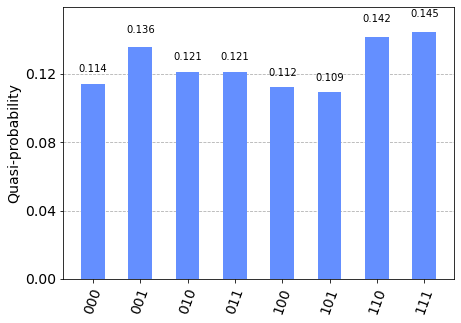

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim, optimization_level=0)

results = aer_sim.run(qc_transpiled).result()
counts = results.get_counts()
plot_distribution(counts)

In [8]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [9]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_2: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

In [10]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

┌─────────┐┌─────────────┐   ┌───┐                                   »
   q_0: ┤ U2(0,π) ├┤ U(0,0,5π/4) ├─X─┤ H ├─■────────────────────────■────────»
        ├─────────┤├─────────────┤ │ └───┘ │P(-π/2) ┌───┐           │        »
   q_1: ┤ U2(0,π) ├┤ U(0,0,5π/2) ├─┼───────■────────┤ H ├─■─────────┼────────»
        ├─────────┤└┬───────────┬┘ │                └───┘ │P(-π/2)  │P(-π/4) »
   q_2: ┤ U2(0,π) ├─┤ U(0,0,5π) ├──X──────────────────────■─────────■────────»
        └─────────┘ └───────────┘                                            »
meas: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«              ░ ┌─┐      
«   q_0: ──────░─┤M├──────
«              ░ └╥┘┌─┐   
«   q_1: ──────░──╫─┤M├───
«        ┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ┤ H ├─░──╫──╫─┤M├
«        └───┘ ░  ║  ║ └╥┘
«meas: 3/═════════╩══╩══╩═
«                 0  1  2

{'101': 1024}


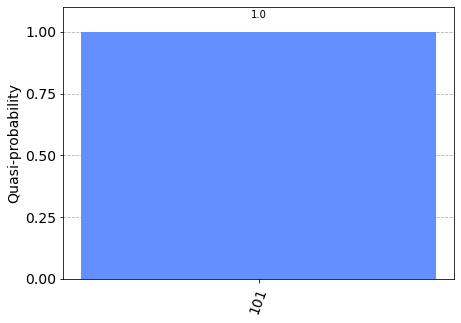

In [11]:
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim, optimization_level=0)

results = aer_sim.run(qc_transpiled).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

## Simulation on Quantum Devices (Q1 Code)

Circuit Depth : 29
{'000': 137, '001': 274, '010': 38, '011': 270, '100': 332, '101': 2614, '110': 131, '111': 204}


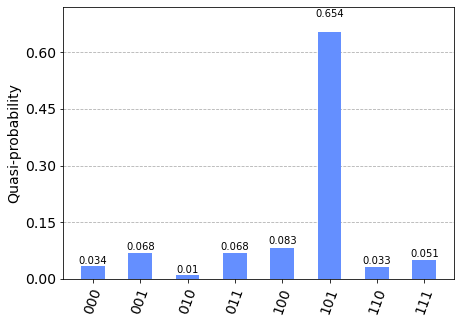

In [12]:
from qiskit.visualization import plot_distribution

backend = provider.get_backend('ibmq_quito')
qc_quito = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4])

print("Circuit Depth :", qc_quito.depth())
results = backend.run(qc_quito).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 29
{'000': 205, '001': 318, '010': 99, '011': 169, '100': 710, '101': 2106, '110': 181, '111': 212}


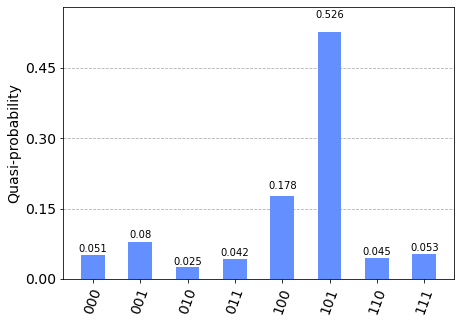

In [13]:
backend = provider.get_backend('ibmq_lima')
qc_lima = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4])

print("Circuit Depth :", qc_lima.depth())
results = backend.run(qc_lima).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 29
{'000': 138, '001': 427, '010': 62, '011': 190, '100': 234, '101': 2684, '110': 68, '111': 197}


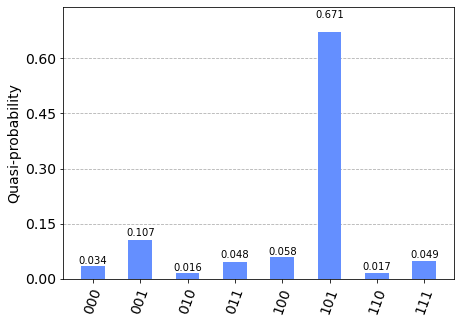

In [14]:
backend = provider.get_backend('ibmq_belem')
qc_belem = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4])

print("Circuit Depth :", qc_belem.depth())
results = backend.run(qc_belem).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 29
{'000': 116, '001': 377, '010': 41, '011': 333, '100': 252, '101': 2612, '110': 44, '111': 225}


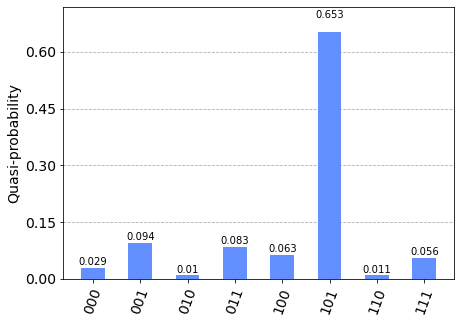

In [15]:
backend = provider.get_backend('ibm_nairobi')
qc_nairobi = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_nairobi.depth())
results = backend.run(qc_nairobi).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 29
{'000': 41, '001': 304, '010': 27, '011': 319, '100': 194, '101': 2824, '110': 94, '111': 197}


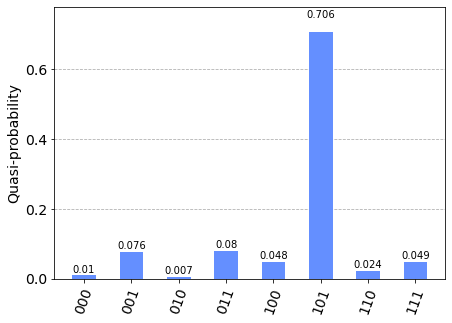

In [16]:
backend = provider.get_backend('ibm_perth')
qc_perth = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_perth.depth())
results = backend.run(qc_perth).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 29


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\qiskit_ibm_provider\ibm_backend.py:437: UserWarning: The backend ibm_lagos is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


{'000': 28, '001': 224, '010': 28, '011': 294, '100': 94, '101': 2909, '110': 73, '111': 350}


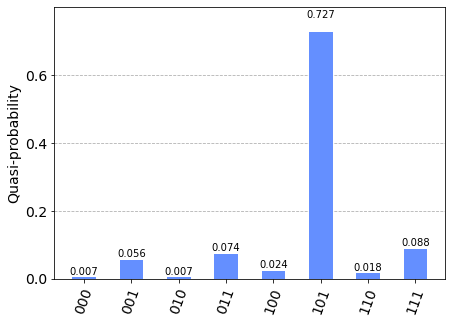

In [17]:
backend = provider.get_backend('ibm_lagos')
qc_lagos = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_lagos.depth())
results = backend.run(qc_lagos).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 29
{'000': 67, '001': 298, '010': 34, '011': 159, '100': 283, '101': 2899, '110': 54, '111': 206}


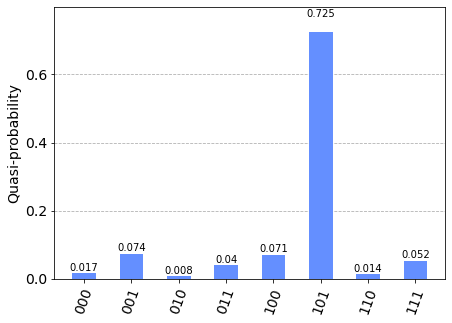

In [18]:
backend = provider.get_backend('ibmq_manila')
qc_manila = transpile(qc, backend, optimization_level=2, initial_layout=[2,3,4])

print("Circuit Depth :", qc_manila.depth())
results = backend.run(qc_manila).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 29
{'000': 48, '001': 327, '010': 32, '011': 128, '100': 264, '101': 2914, '110': 98, '111': 189}


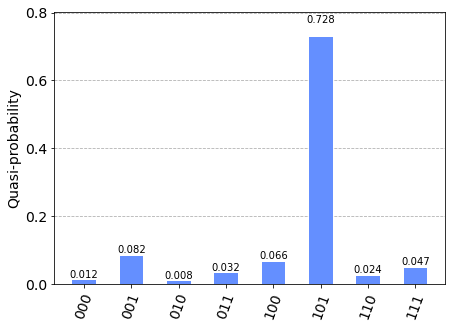

In [19]:
backend = provider.get_backend('ibmq_jakarta')
qc_jakarta = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_jakarta.depth())
results = backend.run(qc_jakarta).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

## Simulation on Quantum Devices (Q2 Code / partially SWAP)

In [12]:
number = 5
qc = QuantumCircuit(5)
qc.h([0,3,4])
qc.p(number*pi/4,0)
qc.p(number*pi/2,3)
qc.p(number*pi,4)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     └───┘└─────────┘
q_1: ────────────────
                     
q_2: ────────────────
     ┌───┐┌─────────┐
q_3: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_4: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

In [13]:
# Encode
qc.barrier()
qc.cx(0,1)
qc.h([0,1])

# CCX_L
qc.barrier()
qc.h([0,1])
qc.ccx(0,1,4)
qc.h([0,1])

# CXX_L
qc.barrier()
qc.h(0)
qc.cx(4,0)
qc.h(0)
qc.h(1)
qc.cx(4,1)
qc.h(1)

# CCX_L
qc.barrier()
qc.h([0,1])
qc.ccx(0,1,4)
qc.h([0,1])

# H_L
qc.barrier()
qc.h(0)
qc.cry(pi,1,0)

# CP_L
qc.barrier()
qc.h([0,1])
qc.mcp(-pi/2, [0,1], 3)
qc.h([0,1])
qc.h(3)

# CP_L
qc.barrier()
qc.h([0,1])
qc.mcp(-pi/4, [0,1], 4)
qc.h([0,1])
qc.cp(-pi/2,3,4)
qc.h(4)

# EF
qc.barrier()
qc.h([0,1])
qc.cx(0,2)
qc.cx(1,2)

qc.barrier()
qc.measure_all()
qc.draw()

┌───┐┌─────────┐ ░      ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌───┐┌───┐     »
   q_0: ┤ H ├┤ P(5π/4) ├─░───■──┤ H ├─░─┤ H ├──■──┤ H ├─░─┤ H ├┤ X ├┤ H ├─────»
        └───┘└─────────┘ ░ ┌─┴─┐├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤└─┬─┘├───┤┌───┐»
   q_1: ─────────────────░─┤ X ├┤ H ├─░─┤ H ├──■──┤ H ├─░─┤ H ├──┼──┤ X ├┤ H ├»
                         ░ └───┘└───┘ ░ └───┘  │  └───┘ ░ └───┘  │  └─┬─┘└───┘»
   q_2: ─────────────────░────────────░────────┼────────░────────┼────┼───────»
        ┌───┐┌─────────┐ ░            ░        │        ░        │    │       »
   q_3: ┤ H ├┤ P(5π/2) ├─░────────────░────────┼────────░────────┼────┼───────»
        ├───┤└┬───────┬┘ ░            ░      ┌─┴─┐      ░        │    │       »
   q_4: ┤ H ├─┤ P(5π) ├──░────────────░──────┤ X ├──────░────────■────■───────»
        └───┘ └───────┘  ░            ░      └───┘      ░                     »
meas: 5/══════════════════════════════════════════════════════════════════════»
                                                                              »
«         ░ ┌───┐     ┌───┐ ░ ┌───┐┌───────┐ ░ ┌───┐          ┌───┐ ░ ┌───┐»
«   q_0: ─░─┤ H ├──■──┤ H ├─░─┤ H ├┤ Ry(π) ├─░─┤ H ├─■────────┤ H ├─░─┤ H ├»
«         ░ ├───┤  │  ├───┤ ░ └───┘└───┬───┘ ░ ├───┤ │        ├───┤ ░ ├───┤»
«   q_1: ─░─┤ H ├──■──┤ H ├─░──────────■─────░─┤ H ├─■────────┤ H ├─░─┤ H ├»
«         ░ └───┘  │  └───┘ ░                ░ └───┘ │        └───┘ ░ └───┘»
«   q_2: ─░────────┼────────░────────────────░───────┼──────────────░──────»
«         ░        │        ░                ░       │P(-π/2) ┌───┐ ░      »
«   q_3: ─░────────┼────────░────────────────░───────■────────┤ H ├─░──────»
«         ░      ┌─┴─┐      ░                ░                └───┘ ░      »
«   q_4: ─░──────┤ X ├──────░────────────────░──────────────────────░──────»
«         ░      └───┘      ░                ░                      ░      »
«meas: 5/══════════════════════════════════════════════════════════════════»
«                                                                          »
«                    ┌───┐         ░ ┌───┐           ░  ░ ┌─┐            
«   q_0: ─■──────────┤ H ├─────────░─┤ H ├──■────────░──░─┤M├────────────
«         │          ├───┤         ░ ├───┤  │        ░  ░ └╥┘┌─┐         
«   q_1: ─■──────────┤ H ├─────────░─┤ H ├──┼────■───░──░──╫─┤M├─────────
«         │          └───┘         ░ └───┘┌─┴─┐┌─┴─┐ ░  ░  ║ └╥┘┌─┐      
«   q_2: ─┼────────────────────────░──────┤ X ├┤ X ├─░──░──╫──╫─┤M├──────
«         │                        ░      └───┘└───┘ ░  ░  ║  ║ └╥┘┌─┐   
«   q_3: ─┼─────────■──────────────░─────────────────░──░──╫──╫──╫─┤M├───
«         │P(-π/4)  │P(-π/2) ┌───┐ ░                 ░  ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ─■─────────■────────┤ H ├─░─────────────────░──░──╫──╫──╫──╫─┤M├
«                            └───┘ ░                 ░  ░  ║  ║  ║  ║ └╥┘
«meas: 5/══════════════════════════════════════════════════╩══╩══╩══╩══╩═
«                                                          0  1  2  3  4

{'10011': 1024}


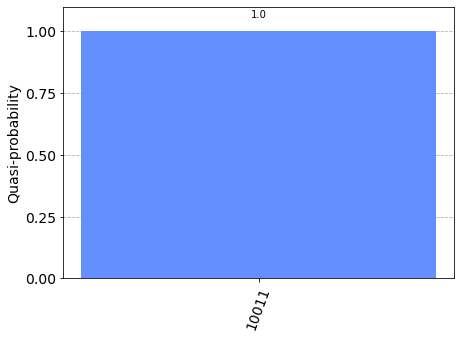

In [14]:
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim, optimization_level=0)

results = aer_sim.run(qc_transpiled).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

In [15]:
number = 5
qc = QuantumCircuit(5)
qc.h([0,3,4])
qc.p(number*pi/4,0)
qc.p(number*pi/2,3)
qc.p(number*pi,4)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     └───┘└─────────┘
q_1: ────────────────
                     
q_2: ────────────────
     ┌───┐┌─────────┐
q_3: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_4: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

In [16]:
# Encode
qc.barrier()
qc.cx(0,1)
qc.h([0,1])

# CCX_L
qc.barrier()
qc.h([0,1])
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)
qc.h([0,1])

# CXX_L
qc.barrier()
qc.h([0,1])
qc.cx(0,1)
qc.cx(4,0)
qc.cx(0,1)
qc.h([0,1])

# CCX_L
qc.barrier()
qc.h([0,1])
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)
qc.h([0,1])

# H_L
qc.barrier()
qc.h(0)
qc.cry(pi,1,0)

# CP_L
qc.barrier()
qc.h([0,1])
qc.cp(-pi/4,0,3)
qc.cx(1,0)
qc.cp(-pi/4,0,3)
qc.cx(1,0)
qc.cp(-pi/4,0,3)
qc.h([0,1])
qc.h(3)

# CP_L
qc.barrier()
qc.h([0,1])
qc.cp(-pi/8,0,4)
qc.cx(1,0)
qc.cp(-pi/8,0,4)
qc.cx(1,0)
qc.cp(-pi/8,0,4)
qc.h([0,1])
qc.cp(-pi/2,3,4)
qc.h(4)

# EF
qc.barrier()
qc.h([0,1])
qc.cx(0,2)
qc.cx(1,2)

qc.measure_all()
qc.draw()

┌───┐┌─────────┐ ░      ┌───┐ ░ ┌───┐      ┌───┐      ┌───┐      ┌───┐»
   q_0: ┤ H ├┤ P(5π/4) ├─░───■──┤ H ├─░─┤ H ├──■───┤ X ├──■───┤ X ├──■───┤ H ├»
        └───┘└─────────┘ ░ ┌─┴─┐├───┤ ░ ├───┤  │   └─┬─┘  │   └─┬─┘  │   ├───┤»
   q_1: ─────────────────░─┤ X ├┤ H ├─░─┤ H ├──┼─────■────┼─────■────┼───┤ H ├»
                         ░ └───┘└───┘ ░ └───┘  │          │          │   └───┘»
   q_2: ─────────────────░────────────░────────┼──────────┼──────────┼────────»
        ┌───┐┌─────────┐ ░            ░        │          │          │        »
   q_3: ┤ H ├┤ P(5π/2) ├─░────────────░────────┼──────────┼──────────┼────────»
        ├───┤└┬───────┬┘ ░            ░      ┌─┴──┐     ┌─┴──┐     ┌─┴──┐     »
   q_4: ┤ H ├─┤ P(5π) ├──░────────────░──────┤ Sx ├─────┤ Sx ├─────┤ Sx ├─────»
        └───┘ └───────┘  ░            ░      └────┘     └────┘     └────┘     »
meas: 5/══════════════════════════════════════════════════════════════════════»
                                                                              »
«         ░ ┌───┐     ┌───┐     ┌───┐ ░ ┌───┐      ┌───┐      ┌───┐      ┌───┐»
«   q_0: ─░─┤ H ├──■──┤ X ├──■──┤ H ├─░─┤ H ├──■───┤ X ├──■───┤ X ├──■───┤ H ├»
«         ░ ├───┤┌─┴─┐└─┬─┘┌─┴─┐├───┤ ░ ├───┤  │   └─┬─┘  │   └─┬─┘  │   ├───┤»
«   q_1: ─░─┤ H ├┤ X ├──┼──┤ X ├┤ H ├─░─┤ H ├──┼─────■────┼─────■────┼───┤ H ├»
«         ░ └───┘└───┘  │  └───┘└───┘ ░ └───┘  │          │          │   └───┘»
«   q_2: ─░─────────────┼─────────────░────────┼──────────┼──────────┼────────»
«         ░             │             ░        │          │          │        »
«   q_3: ─░─────────────┼─────────────░────────┼──────────┼──────────┼────────»
«         ░             │             ░      ┌─┴──┐     ┌─┴──┐     ┌─┴──┐     »
«   q_4: ─░─────────────■─────────────░──────┤ Sx ├─────┤ Sx ├─────┤ Sx ├─────»
«         ░                           ░      └────┘     └────┘     └────┘     »
«meas: 5/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«         ░ ┌───┐┌───────┐ ░ ┌───┐          ┌───┐          ┌───┐          ┌───┐»
«   q_0: ─░─┤ H ├┤ Ry(π) ├─░─┤ H ├─■────────┤ X ├─■────────┤ X ├─■────────┤ H ├»
«         ░ └───┘└───┬───┘ ░ ├───┤ │        └─┬─┘ │        └─┬─┘ │        ├───┤»
«   q_1: ─░──────────■─────░─┤ H ├─┼──────────■───┼──────────■───┼────────┤ H ├»
«         ░                ░ └───┘ │              │              │        └───┘»
«   q_2: ─░────────────────░───────┼──────────────┼──────────────┼─────────────»
«         ░                ░       │P(-π/4)       │P(-π/4)       │P(-π/4) ┌───┐»
«   q_3: ─░────────────────░───────■──────────────■──────────────■────────┤ H ├»
«         ░                ░                                              └───┘»
«   q_4: ─░────────────────░───────────────────────────────────────────────────»
«         ░                ░                                                   »
«meas: 5/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«         ░ ┌───┐          ┌───┐          ┌───┐            ┌───┐         ░ »
«   q_0: ─░─┤ H ├─■────────┤ X ├─■────────┤ X ├─■──────────┤ H ├─────────░─»
«         ░ ├───┤ │        └─┬─┘ │        └─┬─┘ │          ├───┤         ░ »
«   q_1: ─░─┤ H ├─┼──────────■───┼──────────■───┼──────────┤ H ├─────────░─»
«         ░ └───┘ │              │              │          └───┘         ░ »
«   q_2: ─░───────┼──────────────┼──────────────┼────────────────────────░─»
«         ░       │              │              │                        ░ »
«   q_3: ─░───────┼──────────────┼──────────────┼─────────■──────────────░─»
«         ░       │P(-π/8)       │P(-π/8)       │P(-π/8)  │P(-π/2) ┌───┐ ░ »
«   q_4: ─░───────■──────────────■──────────────■─────────■────────┤ H ├─░─»
«         ░                                                        └───┘ ░ »
«meas: 5/═══════════════════

{'10011': 1024}


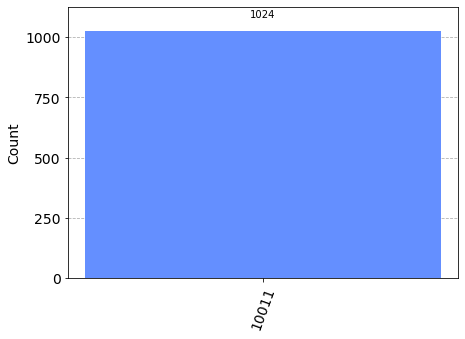

In [17]:
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim, optimization_level=0)

results = aer_sim.run(qc_transpiled).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)